# Practical Assignment 2

In this assignment a perceptron a two layer MLP and a three-layer MLP are trained on the MNIST dataset. The MNIST dataset (provided by Yann Lecun) consists of handwritten digits of which an example is shown in figure 1. 

The networks are trained for 50 epochs with a batch size of 32.

![687474703a2f2f692e7974696d672e636f6d2f76692f3051493378675875422d512f687164656661756c742e6a7067.jpeg](attachment:687474703a2f2f692e7974696d672e636f6d2f76692f3051493378675875422d512f687164656661756c742e6a7067.jpeg)

Figure 1

#### Imports

In [77]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from utils import RandomIterator, get_mnist #as provided in the course
import matplotlib.pyplot as plt
import matplotlib

#### Visualization function

In [78]:
def visualizeLoss(ep_loss, test_loss, nr_epochs=50):
    matplotlib.style.use('ggplot')
    figure = plt.figure(figsize=(15,8))
    ax = figure.add_subplot(111)
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    xticks = np.arange(1, nr_epochs+1, 5)
    ax.set_xticks(xticks)  
    e_train, l_train = [point['epoch'] for point in ep_loss], [point['loss'] for point in ep_loss]
    e_test, l_test = [point['epoch'] for point in test_loss], [point['loss'] for point in test_loss]
    train, = plt.plot(e_train, l_train, 'b', label = 'train loss')
    test, = plt.plot(e_test, l_test, 'r', label = 'test loss')
    plt.legend([train, test], ['train loss', 'test loss'])
    plt.show() 

### Part 1 - training of 3 different neural networks

####  Defining the network
In the class below the structure of the N-layer network is defined. It consists of N linear layers. N is determined by the input parameter "n_layers". 


In [79]:
class NLayerNetwork(Chain):
    """
    
    Implementation of a N-layer Fully Connected network 
    
    """
    def __init__(self, n_units, n_out, n_layers):
        super(NLayerNetwork, self).__init__()
        with self.init_scope():
            self.layers = ChainList()
            self.n_layers = n_layers
            self.l1 = L.Linear(None, n_units)
            for i in range(0, n_layers):
                self.layers.add_link(ChainList(L.Linear(n_units, n_out)))
        
    def __call__(self, x):
        output = F.relu(self.l1(x))
        for i in range(0, self.n_layers):
            output = F.relu(self.layers[i][0](output))
        return output

class Classifier(Chain):
    """
    
    Classifier chain on top of Neural Network chain 
    for accuracy evaluation and prediction
    
    """
    def __init__(self, predictor):
        super(Classifier, self).__init__()
        with self.init_scope():
            self.predictor = predictor
    
    def __call__(self, x, t):
        y = self.predictor(x)
        loss = F.softmax_cross_entropy(y, t)
        accuracy = F.accuracy(y, t)
        report({'loss': loss, 'accuracy': accuracy}, self)
        return loss


#### Training and test set creation

In [80]:
# Retrieve train & test data      
train, test, dimension = get_mnist(n_dim=1)
# split test inputs and labels
inputs, labels = np.array([tup[0] for tup in test]), np.array([tup[1] for tup in test])

# Set up 1 layer model
model_sl = NLayerNetwork(10,10, 1)
classifier_sl = Classifier(model_sl)
optimizer_sl = optimizers.Adam()
optimizer_sl.setup(classifier_sl)

#Set up 2 layer model
model_mlp = NLayerNetwork(10, 10, 2)
classifier_mlp = Classifier(model_mlp)
optimizer_mlp = optimizers.Adam()
optimizer_mlp.setup(classifier_mlp)

#Set up 3 layer model
model_tl = NLayerNetwork(10, 10, 3)
classifier_tl = Classifier(model_tl)
optimizer_tl = optimizers.Adam()
optimizer_tl.setup(classifier_tl)

1


#### Implement the training & test loop


In [81]:
def training(train, test, inputs, labels, classifier, optimizer, nr_of_epochs = 50):
    iterator = RandomIterator(train,32)
    av_loss = []
    ep_loss = []
    test_loss = []
    for epoch in range(1,nr_of_epochs+1):
         for batch in iterator:
            sources,targets = batch[0], batch[1]
            classifier.cleargrads()
            loss = F.sum(classifier(sources, targets))
            loss.backward()
            av_loss.append(loss.data)    
            optimizer.update()
         loss =  sum(av_loss) / len(av_loss)
         ep_loss.append({'epoch': epoch, 'loss': loss})
         # test classifier
         loss = F.sum(classifier(inputs, labels))
         test_loss.append({'epoch': epoch, 'loss': loss.data})
         av_loss = []
    return ep_loss, test_loss

#### Training for 1 layer neural network

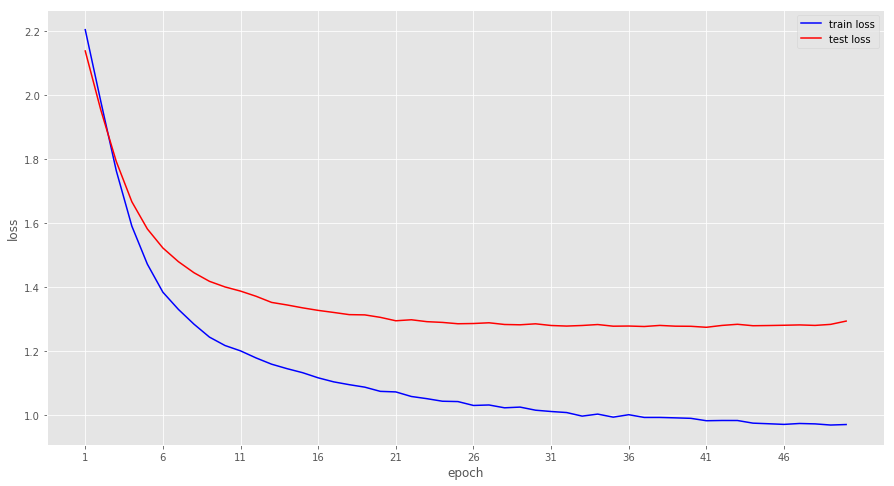

In [82]:
ep_loss, test_loss = training(train, test, inputs, labels, classifier_sl, optimizer_sl)
visualizeLoss(ep_loss, test_loss)

#### Training 2 layer neural network

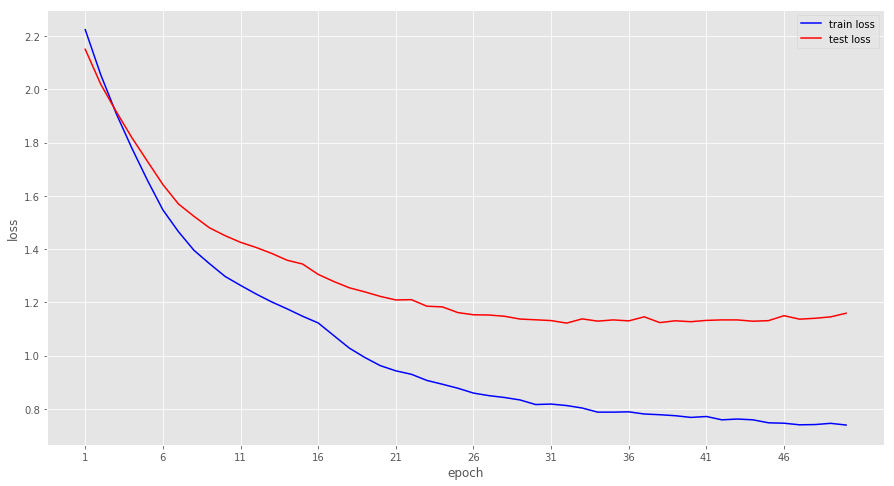

In [83]:
ep_loss, test_loss = training(train, test, inputs, labels, classifier_mlp, optimizer_mlp)
visualizeLoss(ep_loss, test_loss)

#### Training 3 layer neural network

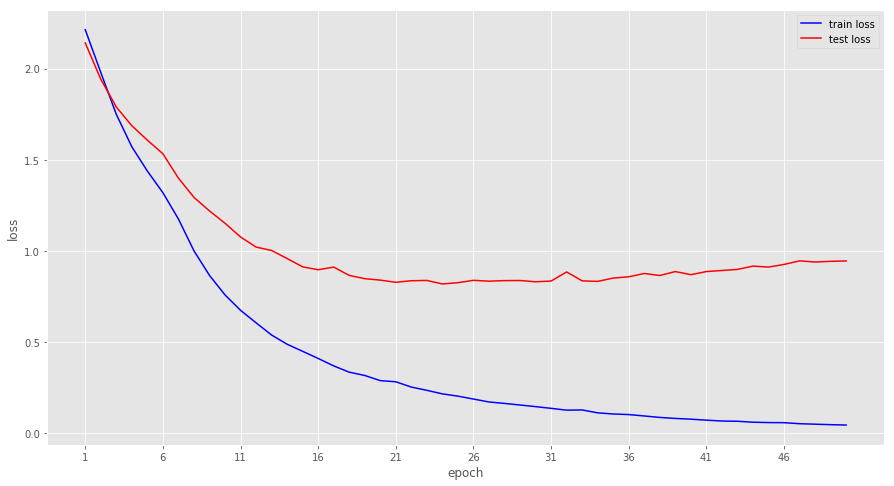

In [84]:
ep_loss, test_loss = training(train, test, inputs, labels, classifier_tl, optimizer_tl)
visualizeLoss(ep_loss, test_loss)

#### Conclusions part 1

#
For N = 1 and N = 2 we see that the test losses converge at around epoch 25 - 30, while the train loss steadily decreases untill around epoch 45. For N = 3 we see a different pattern for the test loss. The test error appears to converge at around epoch 20, but then slowly increases from epoch 30 onwards. 
In all three networks we see that the train loss is lower than the test loss, which is to be expected. However we see that for N = 3 the generalization error is much higher for N = 2 and N= 1 and that for N = 2 the generalization error is similar to N = 1. We conclude that the for this problem the three-layer network overfits on the training data.

### Part 2 - Convolutional Neural Network

Implementation of a convolutional neural network consisting of 1 convolutional layer, 1 max pooling layer and 1 fully connected layer. 

Convolutional layer has 5 outputs, kernel size of 5, stride of 1 and padding of 0

In [85]:
class ConvNet(Chain):
    """
    
    Implementation of a Convolutional Network 
    
    """
    def __init__(self):
        super(ConvNet, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(in_channels=None, out_channels=5, ksize=5, stride=1, pad=0)
            self.l1 = L.Linear(None, 10)
        
    def __call__(self, x):
        h = F.relu(self.conv1(x))
        h = F.max_pooling_2d(h, 2)
        output = F.softmax(self.l1(h))
        return output
    

#### Model creation

In [86]:
model_conv = ConvNet()
classifier_conv = Classifier(model_conv)
optimizer_conv = optimizers.Adam()
optimizer_conv.setup(classifier_conv)

#### Model training

In [87]:
train, test, dimension = get_mnist(n_dim=3)
inputs, labels = np.array([tup[0] for tup in test]), np.array([tup[1] for tup in test])


3


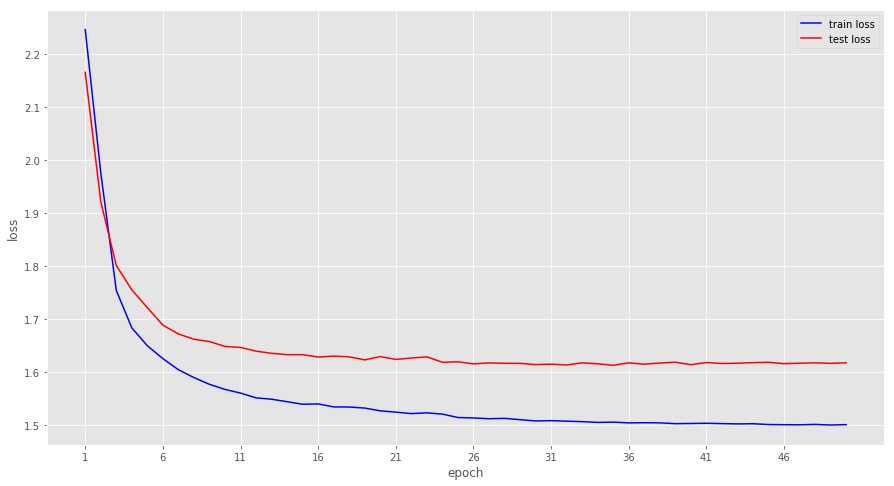

In [88]:
ep_loss, test_loss = training(train, test, inputs, labels, classifier_conv, optimizer_conv)
visualizeLoss(ep_loss, test_loss)

### Conclusions part 2

For the convolutional neural network we see that both the train and test loss convers after roughly 35 epochs. We also see that train loss is significantly lower than the test loss which indicates overfitting.

### Part 3 Explain in which ways convolution is biologically plausible and biologically implausible

#TODO
Convolution is biologically plausible by the fact that it creates so called feature maps that represent a specific feature in the visual area. This is in accordance with how the visual system works, in which neurons are tuned to specific features in the visual field. However, there are several arguments which support the biological implausibility  of convolution. Firstly, in current CNN implementations weights are shared in convolution layers, which is not the case in the visual system. Furthermore, current dominant implementations do not take in account reccurent connections, temporal information through neuronal spiking. 

### Part 4 Model changes

In [89]:
class ConvNetImproved(Chain):
    """
    
    Implementation of a Convolutional Network 
    
    """
    def __init__(self):
        super(ConvNetImproved, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(in_channels=None, out_channels=5, ksize=5, stride=1, pad=0)
            self.conv2 = L.Convolution2D(in_channels=5, out_channels=16, ksize=5, stride=1, pad=0)
            self.l1 = L.Linear(None, 200)
            self.l2 = L.Linear(200, 10)
        
    def __call__(self, x):
        h = F.relu(self.conv1(x))
        h = F.max_pooling_2d(h, 2)
        h = F.relu(self.conv2(h))
        h = F.max_pooling_2d(h, 2)
        h = F.dropout(F.relu(self.l1(h)))
        output = F.softmax(self.l2(h))
        return output

In [90]:
model_conv2 = ConvNetImproved()
classifier_conv2 = Classifier(model_conv2)
optimizer_conv2 = optimizers.Adam()
optimizer_conv2.setup(classifier_conv2)

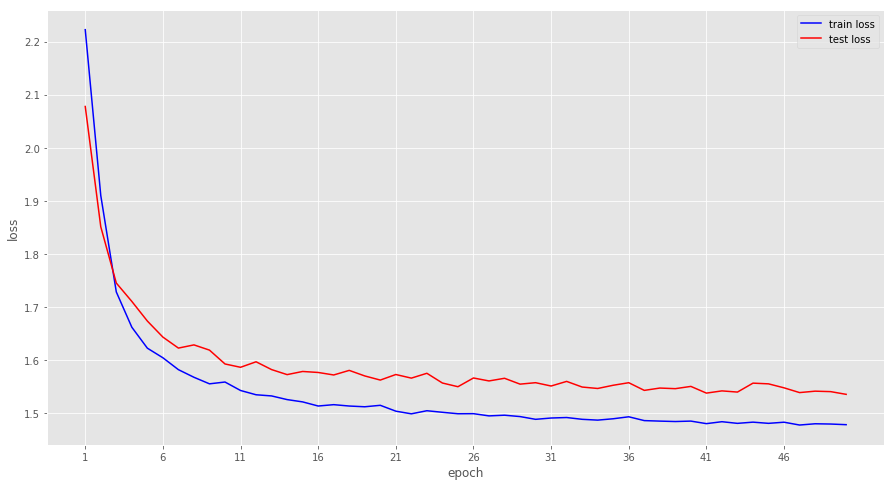

In [91]:
ep_loss, test_loss = training(train, test, inputs, labels, classifier_conv2, optimizer_conv2)
visualizeLoss(ep_loss, test_loss)

### Conclusions Part 4

From the plot we see that the both the train and test converge around epoch 45. While the test loss is similar to the original convnet architecture, the train loss is higher. This suggests that the new architecture has less overfitting issues than the original architecture. 